In [1]:
import numpy as np
import pickle
from psiam_utils import rho_A_t_fn, rho_E_t_fn, cum_A_t_fn, rho_E_minus_t_fn, P_large_t_btn_1_2
from scipy.integrate import quad
from joblib import Parallel, delayed
from pybads import BADS
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.stats import median_abs_deviation
import matplotlib.pyplot as plt

# Read data

In [2]:
with open('psiam_data_5k_2.pkl', 'rb') as f:
    psiam_data = pickle.load(f)


choices = psiam_data['choices']
RTs = psiam_data['RTs']
is_act_resp = psiam_data['is_act_resp']
V_A = psiam_data['V_A']
theta_A = psiam_data['theta_A']
V_E = psiam_data['V_E']
theta_E = psiam_data['theta_E']
Z_E = psiam_data['Z_E']
t_stim = psiam_data['t_stim']


indices_evid = np.where(is_act_resp == 0)[0]
RTs_evid = RTs[indices_evid].flatten()

indices_act = np.where(is_act_resp == 1)[0]
RTs_act = RTs[indices_act].flatten()


RTs = RTs.flatten()

correct_idx = np.where(choices == 1)[0]
wrong_idx = np.where(choices == -1)[0]
non_abort_idx = np.where(RTs >= t_stim)[0]

correct_non_abort_idx = np.intersect1d(correct_idx, non_abort_idx)
wrong_non_abort_idx = np.intersect1d(wrong_idx, non_abort_idx)

correct_RT = RTs[correct_non_abort_idx]
wrong_RT = RTs[wrong_non_abort_idx]

abort_idx = np.where(RTs < t_stim)[0]
abort_RT = RTs[abort_idx]


print(f"V_A: {V_A}")
print(f"theta_A: {theta_A}")
print(f"V_E: {V_E}")
print(f"theta_E: {theta_E}")
print(f"Num of AI process: {is_act_resp.sum()}/{len(is_act_resp)}")
print(f"t start is {t_stim}")

V_A: 1
theta_A: 2
V_E: 0.5
theta_E: 1
Num of AI process: 3765/10000
t start is 0.5


In [3]:
true_params = [V_A, theta_A, V_E, theta_E, Z_E]

In [4]:
def calculate_abort_loglike(t, V_A, theta_A, t_a, abort_norm_term):
    P_A = rho_A_t_fn(t, V_A, theta_A, t_a)
    # p_abort = (P_A * (1 - C_E) + P_E * (1 - C_A))/abort_norm_term
    # Since, C_E = 0 and P_E = 0
    p_abort = P_A/abort_norm_term
    if p_abort <= 0 or np.isnan(p_abort):
        p_abort = 1e-6
    return np.log(p_abort)

def calculate_correct_loglike(t, V_A, theta_A, t_a, V_E, theta_E, Z, K_max, t_stim, t_E, correct_norm_term):
    P_A = rho_A_t_fn(t, V_A, theta_A, t_a)
    P_E_btn_1_2 = P_large_t_btn_1_2(1, 2, t, V_E, theta_E, Z, K_max, t_stim)
    P_E_plus = rho_E_minus_t_fn(t, -V_E, theta_E, K_max, t_stim, -Z, t_E)
    C_A = cum_A_t_fn(t, V_A, theta_A, t_a)
    p_correct = (P_A * P_E_btn_1_2 + P_E_plus * (1 - C_A))/correct_norm_term
    if p_correct <= 0 or np.isnan(p_correct):
        p_correct = 1e-6
    return np.log(p_correct)

def calculate_wrong_loglike(t, V_A, theta_A, t_a, V_E, theta_E, Z, K_max, t_stim, t_E, wrong_norm_term):
    P_A = rho_A_t_fn(t, V_A, theta_A, t_a)
    P_E_btn_0_1 = P_large_t_btn_1_2(0, 1, t, V_E, theta_E, Z, K_max, t_stim)
    P_E_minus = rho_E_minus_t_fn(t, V_E, theta_E, K_max, t_stim, Z, t_E)
    C_A = cum_A_t_fn(t, V_A, theta_A, t_a)
    p_wrong = (P_A * P_E_btn_0_1 + P_E_minus * (1 - C_A))/wrong_norm_term
    if p_wrong <= 0 or np.isnan(p_wrong):
        p_wrong = 1e-6
    return np.log(p_wrong)





def psiam_neg_loglike_fn(params):
    V_A, theta_A, V_E, theta_E, Z = params
    # hyperparams
    t_a = 0; t_E = 0; 
    K_max = 10
    
    # norm terms
    abort_norm_term = 1
    correct_norm_term = 1
    wrong_norm_term = 1

    n_jobs = -1  

    abort_loglike = sum(Parallel(n_jobs=n_jobs)(
        delayed(calculate_abort_loglike)(t, V_A, theta_A, t_a, abort_norm_term)
        for t in abort_RT
    ))
    # abort_loglike = 0
    # for t in abort_RT:
    #     abort_loglike += calculate_abort_loglike(t, V_A, theta_A, t_a, V_E, theta_E, K_max, t_stim, Z, t_E, abort_norm_term)

    correct_loglike = sum(Parallel(n_jobs=n_jobs)(
        delayed(calculate_correct_loglike)(t, V_A, theta_A, t_a, V_E, theta_E, Z, K_max, t_stim, t_E, correct_norm_term)
        for t in correct_RT
    ))
    # correct_loglike = 0
    # for t in correct_RT:
    #     correct_loglike += calculate_correct_loglike(t, V_A, theta_A, t_a, V_E, theta_E, Z, K_max, t_stim, t_E, correct_norm_term)

    wrong_loglike = sum(Parallel(n_jobs=n_jobs)(
        delayed(calculate_wrong_loglike)(t, V_A, theta_A, t_a, V_E, theta_E, Z, K_max, t_stim, t_E, wrong_norm_term)
        for t in wrong_RT
    ))
    # wrong_loglike = 0
    # for t in wrong_RT:
    #     wrong_loglike += calculate_wrong_loglike(t, V_A, theta_A, t_a, V_E, theta_E, Z, K_max, t_stim, t_E, wrong_norm_term)

    total_loglike = abort_loglike + correct_loglike + wrong_loglike

    if np.isnan(total_loglike):
        raise ValueError("Log-likelihood is NaN or infinite.")
    if np.isinf(total_loglike):
        raise ValueError("Log-likelihood is infinite.")

    return -total_loglike

    

# integration checks

In [5]:
from scipy.integrate import quad

V_A, theta_A, V_E, theta_E, Z_E = true_params + np.random.rand(5)
# Z_E = 0
theta_E = 1
# V_A, theta_A, V_E, theta_E, Z_E = true_params + 0.2*np.ones(5)
# V_A, theta_A, V_E, theta_E, Z_E = true_params
print(f'V_A={V_A}, theta_A={theta_A}, V_E={V_E}, theta_E={theta_E}, Z_E={Z_E}')

N = len(RTs)
N_correct = len(correct_RT)
# correct_norm_term = N_correct/N
correct_norm_term = 1
t_a = 0; t_E = 0; K_max = 50
correct_int = quad(calculate_correct_loglike, 0, np.inf, args=(V_A, theta_A, t_a, V_E, theta_E, Z_E, K_max, t_stim, t_E, correct_norm_term))[0]
print(f'Correct Int term = {correct_int}')
# wrong_norm_term = len(wrong_RT)/N
wrong_norm_term = 1
wrong_int = quad(calculate_wrong_loglike, 0, np.inf, args=(V_A, theta_A, t_a, V_E, theta_E, Z_E, K_max, t_stim, t_E, wrong_norm_term))[0]
print(f'Wrong integ term = {wrong_int}')


print(f'correct + wrong int = {correct_int + wrong_int}')


V_A=1.6518156589376294, theta_A=2.890770194462416, V_E=0.7137072907487884, theta_E=1, Z_E=0.8471670235288982
Correct Int term = -104243.8402639908
Wrong integ term = -104382.97682597495
correct + wrong int = -208626.81708996574


/tmp/ipykernel_286862/429019976.py:15: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  correct_int = quad(calculate_correct_loglike, 0, np.inf, args=(V_A, theta_A, t_a, V_E, theta_E, Z_E, K_max, t_stim, t_E, correct_norm_term))[0]
/tmp/ipykernel_286862/429019976.py:19: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  wrong_int = quad(calculate_wrong_loglike, 0, np.inf, args=(V_A, theta_A, t_a, V_E, theta_E, Z_E, K_max, t_stim, t_E, wrong_norm_term))[0]


# Test  loglike

In [7]:
print(f'loglike = {-psiam_neg_loglike_fn([V_A, theta_A, V_E, theta_E, Z_E])}')
print(f'loglike = {-psiam_neg_loglike_fn([2, theta_A, V_E, theta_E, Z_E])}')
print(f'loglike = {-psiam_neg_loglike_fn([2, theta_A, V_E, theta_E, 0.5])}')
print(f'loglike = {-psiam_neg_loglike_fn([V_A, theta_A, V_E, theta_E+0.1, Z_E])}')

loglike = -5566.195970867501
loglike = -6608.940070199026
loglike = -11466.67565084769
loglike = -5803.997354883383


# Parallel BADS

In [7]:
# V_A: 1 # theta_A: 2 # V_E: 0.5 # theta_E: 1 # Z = 0
V_A_bounds = [0.1, 3]; V_A_plausible_bounds = [0.5, 1.5]
theta_A_bounds = [1, 3]; theta_A_plausible_bounds = [1.5, 2.5]
V_E_bounds = [-5, 5]; V_E_plausible_bounds = [-2, 2]
theta_E_bounds = [0.1, 5]; theta_E_plausible_bounds = [0.5,2]
Z_bounds = [-0.5, 0.5]; Z_plausible_bounds = [-0.2, 0.2]


lb = np.array([V_A_bounds[0], theta_A_bounds[0], V_E_bounds[0], theta_E_bounds[0], Z_bounds[0]])
ub = np.array([V_A_bounds[1], theta_A_bounds[1], V_E_bounds[1], theta_E_bounds[1], Z_bounds[1]])
plb = np.array([V_A_plausible_bounds[0], theta_A_plausible_bounds[0], V_E_plausible_bounds[0], theta_E_plausible_bounds[0], Z_plausible_bounds[0]])
pub = np.array([V_A_plausible_bounds[1], theta_A_plausible_bounds[1], V_E_plausible_bounds[1], theta_E_plausible_bounds[1], Z_plausible_bounds[1]])

def run_bads(lb, ub, plb, pub, x0):
    options = {'display': 'off'}
    bads = BADS(psiam_neg_loglike_fn, x0, lb, ub, plb, pub, options=options)
    optimize_result = bads.optimize()

    return optimize_result['x']

def generate_initial_conditions(plb, pub):
    return np.array([
        np.random.uniform(plb[0], pub[0]),  # V_A_0
        np.random.uniform(plb[1], pub[1]),  # theta_A_0
        np.random.uniform(plb[2], pub[2]),  # V_E_0
        np.random.uniform(plb[3], pub[3]),  # theta_E_0
        np.random.uniform(plb[4], pub[4])   # Z_0
    ])

def run_experiment(plb, pub, lb, ub):
    x0 = generate_initial_conditions(plb, pub)
    print(f'Starting point is {x0}')
    res = run_bads(lb, ub, plb, pub, x0)
    return res




In [9]:
N_iters = 10
bads_res_parallel = Parallel(n_jobs=-1)(delayed(run_experiment)(plb, pub, lb, ub) for _ in range(N_iters))

Starting point is [ 0.95295     2.46707721 -0.04648644  0.62959956 -0.11929378]
Starting point is [ 0.95199693  1.5072219   1.32729944  1.14739305 -0.13298129]
Starting point is [1.23859921 2.38824307 1.83404486 1.80558581 0.11346995]
Starting point is [1.23410902 1.98342435 1.19093877 1.62444856 0.07912571]
Starting point is [0.75014029 2.26119622 0.24689625 0.52344133 0.13917495]
Starting point is [ 1.49668484  2.24298246  1.51624946  0.93486063 -0.10756711]
Starting point is [ 0.54641064  1.753403   -0.86650295  0.64391161  0.01730904]
Starting point is [ 1.15768545  1.57105788  1.41479614  1.19648504 -0.10336822]
Starting point is [ 0.61512859  1.58351702 -1.17065311  1.46624215  0.05800026]
Starting point is [0.91703244 2.09770072 0.06388431 1.67964857 0.13412595]


KeyboardInterrupt: 

In [14]:
bads_res_parallel_np = np.array(bads_res_parallel)
with open('bads_res_parallel.pkl', 'wb') as f:
    pickle.dump(bads_res_parallel_np, f)

In [2]:
with open('bads_res_parallel.pkl', 'rb') as f:
    bads_res_parallel_np = pickle.load(f)

#  Serial BADS

In [35]:
all_bads_serial_result = []
N_iters = 10

# TRUE: V_A: 1 # theta_A: 2 # V_E: 0.5 # theta_E: 1 # Z = 0
V_A_bounds = [0.1, 3]; V_A_plausible_bounds = [0.5, 1.5]
theta_A_bounds = [1, 3]; theta_A_plausible_bounds = [1.5, 2.5]
V_E_bounds = [-5, 5]; V_E_plausible_bounds = [-2, 2]
theta_E_bounds = [0.1, 5]; theta_E_plausible_bounds = [0.5,2]
Z_bounds = [-0.5, 0.5]; Z_plausible_bounds = [-0.2, 0.2]

lb = np.array([V_A_bounds[0], theta_A_bounds[0], V_E_bounds[0], theta_E_bounds[0], Z_bounds[0]])
ub = np.array([V_A_bounds[1], theta_A_bounds[1], V_E_bounds[1], theta_E_bounds[1], Z_bounds[1]])
plb = np.array([V_A_plausible_bounds[0], theta_A_plausible_bounds[0], V_E_plausible_bounds[0], theta_E_plausible_bounds[0], Z_plausible_bounds[0]])
pub = np.array([V_A_plausible_bounds[1], theta_A_plausible_bounds[1], V_E_plausible_bounds[1], theta_E_plausible_bounds[1], Z_plausible_bounds[1]])


for _ in tqdm(range(N_iters)):
    x0 = np.array([
        np.random.uniform(plb[0], pub[0]),  # V_A_0
        np.random.uniform(plb[1], pub[1]),  # theta_A_0
        np.random.uniform(plb[2], pub[2]),  # V_E_0
        np.random.uniform(plb[3], pub[3]),  # theta_E_0
        np.random.uniform(plb[4], pub[4])   # Z_0
    ])

    res = run_bads(lb, ub, plb, pub, x0)
    all_bads_serial_result.append(res)

100%|██████████| 10/10 [41:26<00:00, 248.61s/it]


In [15]:
# all_bads_serial_results_np = np.array(all_bads_serial_result)
all_bads_serial_results_np = bads_res_parallel_np


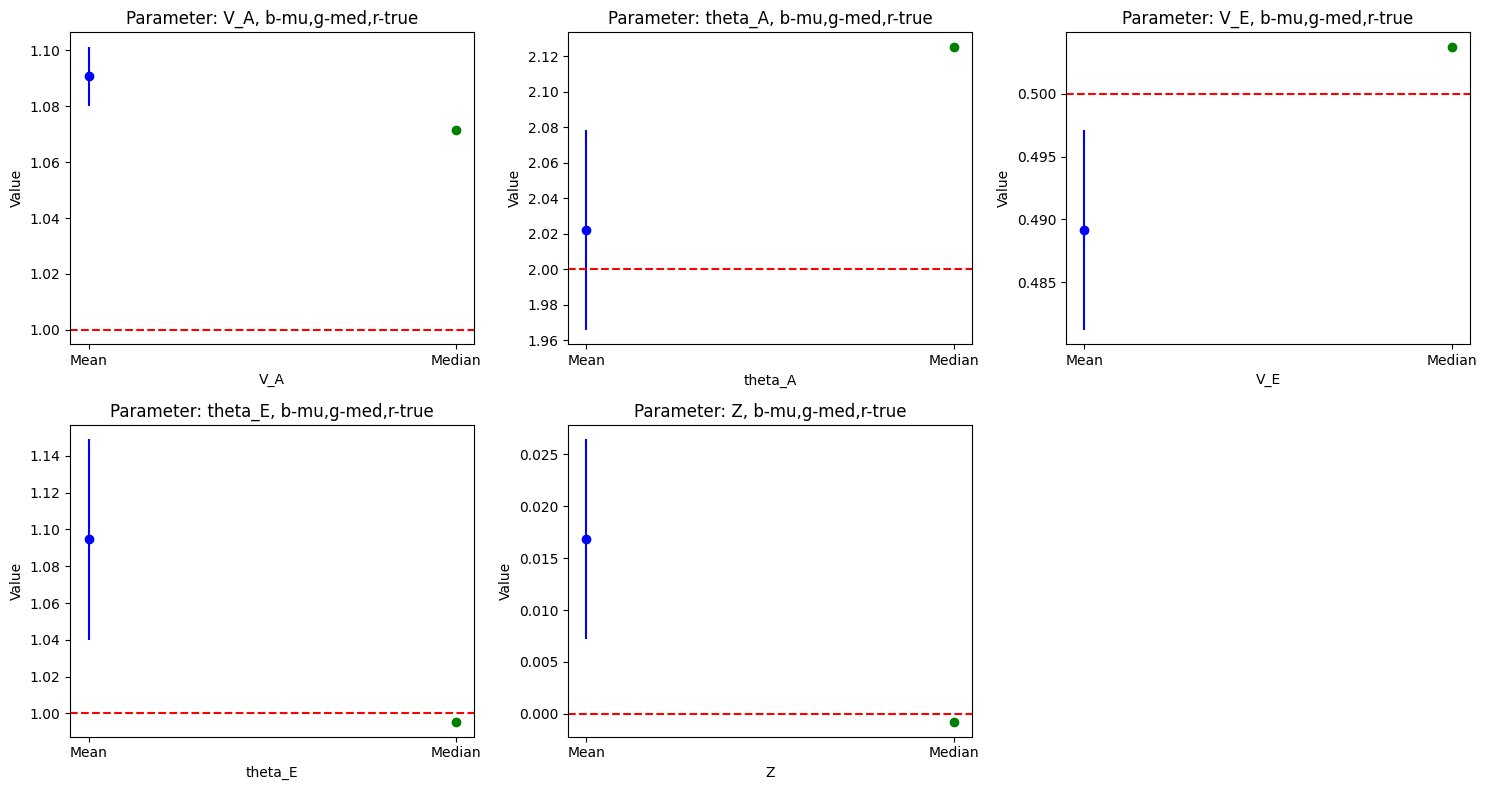

In [16]:
param_names = ["V_A", "theta_A", "V_E", "theta_E", "Z"]
true_values = [1, 2, 0.5, 1, 0]

# Create a figure with 6 subplots in a 2x3 grid
fig, axs = plt.subplots(2, 3, figsize=(15, 8))  # 2x3 layout for subplots

# Flatten axs for easier indexing
axs = axs.flatten()

# Iterate over each parameter to plot
for i in range(5):
    param_data = all_bads_serial_results_np[:, i]
    
    # Compute mean, SE, median, and MAD
    mean_val = np.mean(param_data)
    se_val = np.std(param_data) / np.sqrt(len(param_data))  # Standard error
    median_val = np.median(param_data)
    mad_val = median_abs_deviation(param_data)  # MAD
    
    # Plot mean with SE
    axs[i].errorbar(1, mean_val, yerr=se_val, fmt='o', color='blue', label='Mean ± SE')
    
    # Plot median with MAD
    axs[i].errorbar(2, median_val, yerr=mad_val, fmt='o', color='green', label='Median ± MAD')
    
    # Mark the true value
    axs[i].axhline(true_values[i], color='red', linestyle='--', label='True Value')
    
    # Add titles and labels
    axs[i].set_title(f'Parameter: {param_names[i]}, b-mu,g-med,r-true')
    axs[i].set_xticks([1, 2])
    axs[i].set_xticklabels(['Mean', 'Median'])
    axs[i].set_xlabel(param_names[i])
    axs[i].set_ylabel('Value')
    
    # Show legend
    # axs[i].legend()

# Hide the empty subplot
axs[5].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


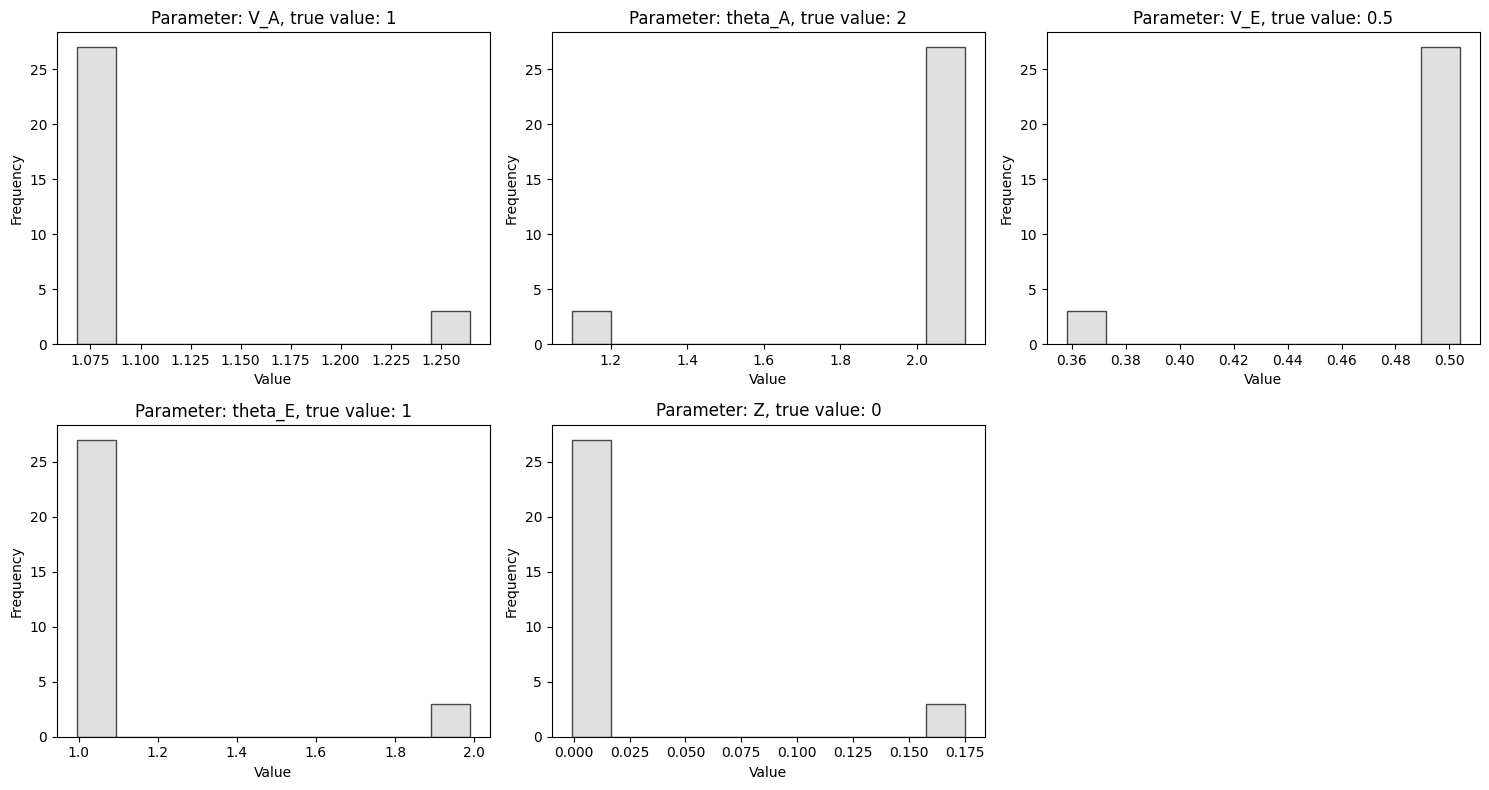

In [17]:

param_names = ["V_A", "theta_A", "V_E", "theta_E", "Z"]
true_values = [1, 2, 0.5, 1, 0]

# Create a figure with 6 subplots in a 2x3 grid
fig, axs = plt.subplots(2, 3, figsize=(15, 8))  # 2x3 layout for subplots

# Flatten axs for easier indexing
axs = axs.flatten()

# Iterate over each parameter to plot
for i in range(5):
    param_data = all_bads_serial_results_np[:, i]
    
    # Compute mean, median
    mean_val = np.mean(param_data)
    median_val = np.median(param_data)
    
    # Plot the histogram
    axs[i].hist(param_data, bins=10, color='lightgray', edgecolor='black', alpha=0.7, label='Distribution')
    
    # Plot mean, median, and true value lines
    # axs[i].axvline(mean_val, color='blue', linestyle='-', linewidth=2, label='Mean')
    # axs[i].axvline(median_val, color='green', linestyle='-', linewidth=2, label='Median')
    # axs[i].axvline(true_values[i], color='red', linestyle='--', linewidth=2, label='True Value')
    
    # Add titles and labels
    axs[i].set_title(f'Parameter: {param_names[i]}, true value: {true_values[i]}')
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')
    
    # Show legend
    # axs[i].legend()

# Hide the empty subplot
axs[5].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


# Single bads

In [5]:
# V_A: 1 # theta_A: 2 # V_E: 0.5 # theta_E: 1 # Z = 0
V_A_bounds = [0.1, 3]; V_A_plausible_bounds = [0.5, 1.5]
theta_A_bounds = [1, 3]; theta_A_plausible_bounds = [1.5, 2.5]
V_E_bounds = [-5, 5]; V_E_plausible_bounds = [-2, 2]
theta_E_bounds = [0.1, 5]; theta_E_plausible_bounds = [0.5,1.5]
Z_bounds = [-0.5, 0.5]; Z_plausible_bounds = [-0.2, 0.2]

# V_A_bounds = [0.5, 1.5]; V_A_plausible_bounds = [0.7, 1.3]
# theta_A_bounds = [1.5, 2.5]; theta_A_plausible_bounds = [1.7, 2.2]
# V_E_bounds = [0, 1]; V_E_plausible_bounds = [0.2, 0.7]
# theta_E_bounds = [0.1, 2]; theta_E_plausible_bounds = [0.5,1.5]
# Z_bounds = [-0.2, 0.2]; Z_plausible_bounds = [-0.1, 0.1]

lb = np.array([V_A_bounds[0], theta_A_bounds[0], V_E_bounds[0], theta_E_bounds[0], Z_bounds[0]])
ub = np.array([V_A_bounds[1], theta_A_bounds[1], V_E_bounds[1], theta_E_bounds[1], Z_bounds[1]])
plb = np.array([V_A_plausible_bounds[0], theta_A_plausible_bounds[0], V_E_plausible_bounds[0], theta_E_plausible_bounds[0], Z_plausible_bounds[0]])
pub = np.array([V_A_plausible_bounds[1], theta_A_plausible_bounds[1], V_E_plausible_bounds[1], theta_E_plausible_bounds[1], Z_plausible_bounds[1]])


V_A_0 = np.random.uniform(plb[0], pub[0])
theta_A_0 =  np.random.uniform(plb[1], pub[1])
V_E_0 = np.random.uniform(plb[2], pub[2])
theta_E_0 = np.random.uniform(plb[3], pub[3])
Z_0 = np.random.uniform(plb[4], pub[4])

x0 = np.array([V_A_0, theta_A_0, V_E_0, theta_E_0, Z_0]);

options = {'display': 'off'}
bads = BADS(psiam_neg_loglike_fn, x0, lb, ub, plb, pub, options=options)
optimize_result = bads.optimize()
x_min = optimize_result['x']


# V_A: 1 # theta_A: 2 # V_E: 0.5 # theta_E: 1 # Z = 0
print(f'Est. V_A = {x_min[0]}, True V_A = {V_A}')
print(f'Est. theta_A = {x_min[1]}, True theta_A = {theta_A}')
print(f'Est. V_E = {x_min[2]}, True V_E = {V_E}')
print(f'Est. theta_E = {x_min[3]}, True theta_E = {theta_E}')
print(f'Est. Z = {x_min[4]}, True Z = {Z_E}')

Est. V_A = 0.9476237176772884, True V_A = 1
Est. theta_A = 1.9397332968937917, True theta_A = 2
Est. V_E = 0.4983929461141088, True V_E = 0.5
Est. theta_E = 1.000497462619478, True theta_E = 1
Est. Z = -0.003662720325883129, True Z = 0


# likelihood true params vs BADS est

In [8]:
t_a = 0;  K_max = 50; t_E = 0
correct_norm_term = len(correct_RT)/len(RTs)
wrong_norm_term = len(wrong_RT)/len(RTs)

print(correct_norm_term, wrong_norm_term)
# true
V_A, theta_A, V_E, theta_E, Z = true_params

t_pts = correct_RT
correct_p_bads = np.zeros(len(t_pts))
for i, t in enumerate(t_pts):
    correct_p_bads[i] = calculate_correct_loglike(t, V_A, theta_A, t_a, V_E, theta_E, Z, K_max, t_stim, t_E, correct_norm_term)

t_pts = wrong_RT
wrong_p_bads = np.zeros(len(t_pts))
for i, t in enumerate(t_pts):
    wrong_p_bads[i] = calculate_wrong_loglike(t, V_A, theta_A, t_a, V_E, theta_E, Z, K_max, t_stim, t_E, wrong_norm_term)

total_loglike = np.sum(correct_p_bads) + np.sum(wrong_p_bads)
print(f"True params: V_A={V_A:.2f}, theta_A={theta_A:.2f}, V_E={V_E:.2f}, theta_E={theta_E:.2f}, Z={Z:.2f}, total loglike={total_loglike:.2f}")


V_A, theta_A, V_E, theta_E, Z = x_min

t_pts = correct_RT
correct_p_bads = np.zeros(len(t_pts))
for i, t in enumerate(t_pts):
    correct_p_bads[i] = calculate_correct_loglike(t, V_A, theta_A, t_a, V_E, theta_E, Z, K_max, t_stim, t_E, correct_norm_term)

t_pts = wrong_RT
wrong_p_bads = np.zeros(len(t_pts))
for i, t in enumerate(t_pts):
    wrong_p_bads[i] = calculate_wrong_loglike(t, V_A, theta_A, t_a, V_E, theta_E, Z, K_max, t_stim, t_E, wrong_norm_term)

total_loglike = np.sum(correct_p_bads) + np.sum(wrong_p_bads)
print(f"BADS params: V_A={V_A:.2f}, theta_A={theta_A:.2f}, V_E={V_E:.2f}, theta_E={theta_E:.2f}, Z={Z:.2f}, total loglike={total_loglike:.2f}")



0.7052 0.2948
True params: V_A=1.00, theta_A=2.00, V_E=0.50, theta_E=1.00, Z=0.00, total loglike=-5566.20
BADS params: V_A=1.50, theta_A=2.39, V_E=0.53, theta_E=0.85, Z=-0.02, total loglike=-4986.38


# K value?

In [21]:
def loglike_K(K_max):
    Z = Z_E
    # hyperparams
    t_a = 0; t_E = 0; 
    
    # norm terms
    N = len(RTs)
    N_abort = len(abort_RT)
    N_correct = len(correct_RT)
    N_wrong = len(wrong_RT)

    abort_norm_term = N_abort/N
    correct_norm_term = N_correct/N
    wrong_norm_term = N_wrong/N
    n_jobs = -1  

    abort_loglike = sum(Parallel(n_jobs=n_jobs)(
        delayed(calculate_abort_loglike)(t, V_A, theta_A, t_a, V_E, theta_E, K_max, t_stim, Z, t_E, abort_norm_term)
        for t in abort_RT
    ))
    # abort_loglike = 0
    # for t in abort_RT:
    #     abort_loglike += calculate_abort_loglike(t, V_A, theta_A, t_a, V_E, theta_E, K_max, t_stim, Z, t_E, abort_norm_term)

    correct_loglike = sum(Parallel(n_jobs=n_jobs)(
        delayed(calculate_correct_loglike)(t, V_A, theta_A, t_a, V_E, theta_E, Z, K_max, t_stim, t_E, correct_norm_term)
        for t in correct_RT
    ))
    # correct_loglike = 0
    # for t in correct_RT:
    #     correct_loglike += calculate_correct_loglike(t, V_A, theta_A, t_a, V_E, theta_E, Z, K_max, t_stim, t_E, correct_norm_term)

    wrong_loglike = sum(Parallel(n_jobs=n_jobs)(
        delayed(calculate_wrong_loglike)(t, V_A, theta_A, t_a, V_E, theta_E, Z, K_max, t_stim, t_E, wrong_norm_term)
        for t in wrong_RT
    ))
    # wrong_loglike = 0
    # for t in wrong_RT:
    #     wrong_loglike += calculate_wrong_loglike(t, V_A, theta_A, t_a, V_E, theta_E, Z, K_max, t_stim, t_E, wrong_norm_term)

    total_loglike = abort_loglike + correct_loglike + wrong_loglike

    if np.isnan(total_loglike):
        raise ValueError("Log-likelihood is NaN or infinite.")
    if np.isinf(total_loglike):
        raise ValueError("Log-likelihood is infinite.")

    return -total_loglike

In [22]:
k_range = np.linspace(5, 50, 10)
log_vs_k = [loglike_K(int(k)) for k in k_range]

In [25]:
log_vs_k, k_range

([15421.453093435675,
  15426.350805780366,
  15428.295319583754,
  15428.09295278749,
  15427.841301157463,
  15427.871386448802,
  15427.928677812179,
  15427.92164042249,
  15427.904817182742,
  15427.90680682211],
 array([ 5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]))

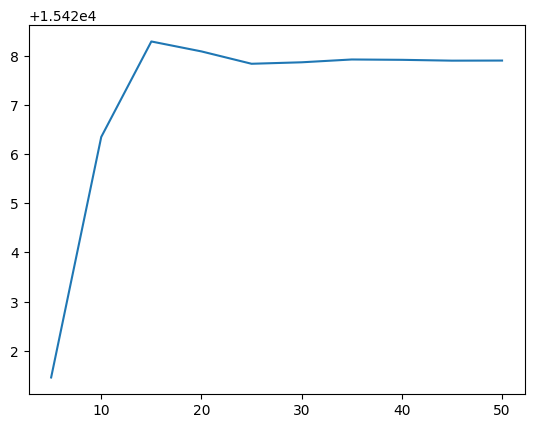

In [24]:
plt.plot(k_range, log_vs_k)

In [16]:
a = np.sum(np.array([calculate_abort_loglike(t, V_A+0.1, theta_A+0.1, 0, V_E+0.1, theta_E+0.1, 50, t_stim, Z_E, 0, len(abort_RT)/len(RTs)) for t in abort_RT]))
print(a)

350.91828127473923


In [13]:
def calculate_abort_loglike_2(t, V_A, theta_A, t_a, V_E, theta_E, K_max, t_stim, Z, t_E, abort_norm_term):
    P_A = rho_A_t_fn(t, V_A, theta_A, t_a)
    C_E = quad(rho_E_t_fn, 0, t, args=(V_E, theta_E, K_max, t_stim, Z, t_E))[0]
    P_E = rho_E_t_fn(t, V_E, theta_E, K_max, t_stim, Z, t_E)
    C_A = cum_A_t_fn(t, V_A, theta_A, t_a)
    p_abort = (P_A * (1 - C_E) + P_E * (1 - C_A))/abort_norm_term
    if p_abort <= 0:
        p_abort = 1e-16
    # return np.log(p_abort)
    return p_abort
quad(calculate_abort_loglike_2, 0, t_stim, args=(V_A, theta_A, 0, V_E, theta_E, 100, t_stim, Z_E, 0, len(abort_RT)/len(RTs)))[0]

0.9415047119033454

In [10]:
a

411.7034067897759